In [27]:
import numpy as np
import random
import collections
import time
from math import floor
import matplotlib.pyplot as plt

# document variables

D = 0 # number of documents
W = 0 # number of words in the vocabulary
NNZ = 0 # number of non-zero counters in the file

# user input variables

numDocuments = 5 # here I store how many documents I will read
fileName = ""
numNeighbors = 0
K = 20
similarity_choice = 0 # 1 : JacSim, 2 : SigSim
method_choice = 0 # 1 : Brute force, 2 : LSH
rowsPerBand = 0

The following function reads from a file determined by the parameter 'filename' and returns a list of frozensets, one frozenset for each of the numDocuments documents we read. Each frozenset contains the word id's that the corresponding document is associated with. We read the file line by line and from each line save the document id and the word id. While the document id remains the same (and less than the wanted number of documents we want to read, determined by the value of the parameter 'numDocuments'), I add the new word id I come across to a list. When the document id I come across changes, it is time for the list to be turned into a frozenset and for it to be appended t o a list of all the frozensets.

In [2]:
def MyReadDataRoutine(numDocuments, filename):
    reader = open(filename, "r")
    global D, W, NNZ

    # number of documents
    D = int(reader.readline())
    # number of different vocabulary words
    W = int(reader.readline())
    # number of non-zero counters in the file
    NNZ = int(reader.readline())

    line = reader.readline().split(' ')[:-1] # get rid of '\n' character and take only the id's and word count
    current_docID = int(line[0])
    wordID = int(line[1])
    currentWordList = [] # keep list of word id's until we read every id and need to convert to frozenset
    currentWordList.append(wordID)
    frozenset_list = []

    while(current_docID <= numDocuments):
        line = reader.readline().split(' ')[:-1] # get rid of '\n' character and take only the id's and word count

        if line == []: # case of EOF
            ready_frozenset = frozenset(currentWordList)
            frozenset_list.append(ready_frozenset)
            break

        docID = int(line[0])
        wordID = int(line[1])

        if(docID == current_docID):
            currentWordList.append(wordID)
        else:
            ready_frozenset = frozenset(currentWordList)
            frozenset_list.append(ready_frozenset)
            current_docID = docID
            currentWordList = [wordID]

    return frozenset_list

In [6]:
frozenset_list = MyReadDataRoutine(numDocuments, 'DATA_1-docword.enron.txt')

In [7]:
print(frozenset_list[0])
print(frozenset_list[1])

frozenset({25611, 9358, 20240, 27283, 2068, 1688, 6941, 285, 5299, 7223, 9784, 17208, 23481, 13631, 12224, 9667, 8904, 1229, 17872, 23893, 11099, 18139, 14814, 27359, 14816, 11763, 23028, 118, 19190, 12669})
frozenset({14338, 9732, 2053, 23557, 17423, 12818, 2068, 536, 9755, 19484, 17955, 20520, 46, 9289, 18505, 17486, 21077, 18522, 9832, 10344, 3182, 3183, 19568, 24174, 12405, 11896, 11897, 1669, 19589, 19613, 4777, 1197, 2233, 26297, 4802, 19651, 14024, 26324, 19675, 19168, 8930, 4843, 9458, 14075, 4860, 1290, 19724, 19725, 7457, 16673, 22310, 21290, 4398, 821, 14649, 13631, 17728, 11585, 20290, 325, 4943, 6993, 15187, 1889, 24436, 24445, 25469, 15231, 5511, 5006, 20366, 20371, 20374, 22934, 21913, 22435, 4516, 25539, 24521, 5066, 8655, 20956, 26076, 20958, 5602, 9707, 23028})


Next, we build two different functions for the Jaccard similarity computation. The 'MyJacSimWithSets' function is the naive function which uses a double loop in order to find the number of elements of the intersection of the two document sets. We have a counter for the word id's that are found in both documents and taking advantage of the fact that we can mathematically express the union of the sets using the intersection of them, we compute the Jaccard similarity.

The 'MyJacSimWithOrderedLists' works with only one passage from the frozensets, since it sorts the two frozensets in the beginning.

In [8]:
def MyJacSimWithSets(docID1, docID2):
    global frozenset_list

    frozenset1 = frozenset_list[docID1]
    frozenset2 = frozenset_list[docID2]
    intersection_counter = 0

    for wordID1 in frozenset1:
        for wordID2 in frozenset2:
            if wordID1 == wordID2:
                intersection_counter += 1

    return intersection_counter / (len(frozenset1) + len(frozenset2) - intersection_counter)

def MyJacSimWithOrderedLists(docID1, docID2):
    pos1 = 0
    pos2 = 0
    intersection_counter = 0

    frozenset1 = list(frozenset_list[docID1])
    frozenset2 = list(frozenset_list[docID2])

    frozenset1.sort()
    frozenset2.sort()

    len1 = len(frozenset1)
    len2 = len(frozenset2)

    while(pos1 < len1 and pos2 < len2):
        if(frozenset1[pos1] == frozenset2[pos2]):
            intersection_counter += 1
            pos1 += 1
            pos2 += 1
        else:
            if(frozenset1[pos1] < frozenset2[pos2]):
                pos1 += 1
            else:
                pos2 += 1

    return intersection_counter / (len1 + len2 - intersection_counter)

In [9]:
# testing the functions

print(MyJacSimWithSets(1,2))
print(MyJacSimWithSets(2,2))
print(MyJacSimWithOrderedLists(1,2))
print(MyJacSimWithOrderedLists(0,2))

0.02040816326530612
1.0
0.02040816326530612
0.014184397163120567


The following cell demonstrates the function "create_random_permutation()" which is used to create a permutation of the word id's, that is, a new random index sequence for them to appear in. The permutations are needed in order for the MinHash algorithm to work, as we know.

In [10]:
def create_random_hash_function(p=2**33-355, m=2**32-1):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: 1 + (((a * x + b) % p) % m)

def create_random_permutation():
    global W # number of different vocabulary words

    h = create_random_hash_function()
    randomHash = { x:h(x) for x in range(W) }

    myHashKeysOrderedByValues = sorted(randomHash, key=randomHash.get)
    myHash = { myHashKeysOrderedByValues[x] : x for x in range(W)}

    return myHash

Next up we present the function that constructs the signature matrix. In order to avoid creating a very sparse matrix (the size of numWords * numDocuments cells) which contains a 1 in the cells (r,c) when the word indexed by r appears in the document indexed by c, we construct a matrix wordsList which, in each index wordID contains a list of the id's of the documents in which the word appears. In order to create this matrix, I run through the frozenset list and for each wordID that the corresponding document contains, I append to the list wordList[wordID - 1] the docID of the document.

Next up, we create the number of k different permutations using the functions above. Then, we run a time-efficient version of the MinHash algorithm, which only needs to pass through the wordList once, instead of one time for each permutation. We construct a signature matrix, which has a number of rows just as many as the permutations and a number of columns just as many as the documents and initialise all values to -1 which represents infinity. Then, passing through each row of the wordList, for each docID that we find (these IDs correspond to the spots in which this row has 1's), we change the value of the signature matrix spot that corresponds to the docID and the permutation to the permutation value of the wordID, if the permutation value of the wordID is lower than the stored value. This makes sure that when we have passed through the whole wordList, each document will have the lowest value for each permutation.




In [11]:
def MyMinHash(documentsList, K):
    # Create word list

    global numDocuments, W

    wordsList = [[] for i in range(W)]  # wordList[wordD - 1] contains all the docID's of the documents in which the word is contained

    for i in range(numDocuments):
        document = documentsList[i] # contains the word ID's of the document

        for wordID in document:
            wordsList[wordID - 1].append(i + 1) # store the document ID where it belongs

   # Create K random permutations

    list_of_permutations = []

    for i in range(K):
        permutation = create_random_permutation()
        list_of_permutations.append(permutation)

    # Initialise signature matrix

    signature_matrix = [[-1 for i in range(numDocuments)] for j in range(K)] # -1 means infinite

    # Scan wordsList and create signatures

    for row_count, row in enumerate(wordsList):
        for col in row:
            for perm in range(K):
                if list_of_permutations[perm][row_count] < signature_matrix[perm][col - 1] or signature_matrix[perm][col - 1] == -1:
                    signature_matrix[perm][col - 1] = list_of_permutations[perm][row_count]

    return signature_matrix

In [12]:
sig_m = MyMinHash(frozenset_list, K)

ΜySigSim(): The function that calculates the signature similarity between two different documents. It counts the number of signatures in which the two documents are the same and then divides by the number of permutations used for the similarity calculation.

AvgSim(): The function that counts the average similarity that a document has with its numNeighbors closest neighbors. It can work two ways, one way is using the Jaccard similarity and the other is by using the signature similarity. At first, we count the distances of the document from all other documents and then, after sorting, we store a dictionary 'myNeighborsDict' which stores pairs in the form of docID : similarity (1 - distance).


In [35]:
def MySigSim(docID1, docID2, numPermutations):
    global sig_m
    count_of_same_signatures = 0

    for i in range(numPermutations):
        if sig_m[i][docID1] == sig_m[i][docID2]:
            count_of_same_signatures += 1

    return count_of_same_signatures / numPermutations

def AvgSim(docID, numNeighbors, case = 1):
    global K
    distances = {i : 0 for i in range(numDocuments)}

    if case == 1: # Jaccard Similarity

        for i in range(numDocuments):
            distances[i] = (1 - MyJacSimWithOrderedLists(docID, i))

    elif case == 2: # Signature Similarity

        for i in range(numDocuments):
            distances[i] = (1 - MySigSim(docID, i, K))


    distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}

    myNeighborsDict = {k: (1 - distances[k]) for k in list(distances)[:numNeighbors]}
    similarities = list(myNeighborsDict.values())
    avgSim = 0

    for i in range(numNeighbors):
        avgSim += similarities[i]

    avgSim = avgSim / numNeighbors

    return avgSim, myNeighborsDict

In [14]:
# testing how close the average and closest-neighbor similarity values are
# when computed using jaccard/signature similarity

jaccard_res = AvgSim(docID = 3, numNeighbors = 3, case = 1) # Jaccard similarity
print(jaccard_res[0], jaccard_res[1])

sig_res = AvgSim(docID = 3, numNeighbors = 3, case = 2) # Signature similarity
print(sig_res[0], sig_res[1])

0.3511314920233326 {3: 1.0, 1: 0.040322580645161255, 2: 0.013071895424836555}
0.35000000000000003 {3: 1.0, 2: 0.050000000000000044, 0: 0.0}


LSH_calculations: the function that encapsulates the calculations of the LSH algorithm. It starts by calculating the number of bands that will be created according to the rows per band that is given. Then, for each band, we extract the signature vector that corresponds to each document in order to hash it. We store the hash values for each band. Then, we find all possible pairs of documents that need to be checked (note: possible pairs are pairs of documents whose signature was hashed in the same bucket for at least one band). It is important that we also count the number of times a document appears in a possible pair, so that we make sure it is over the 'numNeighbors' threshold. The function returns the potential pairs and a list of the number of times each documents appeared in a potential pair.

The LSH function is parameterised by an initial choice for the number of rows per band and uses the LSH_calculations function according to this value. If the calculations function finds that at least on document has less than the numNeighbors number of potential pairs, then the calculations function is repeated for half the number of rows per band (which of course makes it easier for band vectors to match).

Once the above process is completed and we get enough pairs for all documents, we proceed to calculate the similarities of each pair, according to the choice of similarity function. We return a list of the average similarity of each document to its nearest numNeighbors and a list of the nearest neighbors of each document, paired with the corresponding distance between them.





In [15]:
def LSH_calculations(sig_sim_matrix, rowsPerBand):
    global K
    global numNeighbors
    global numDocuments

    numBands = floor(K / rowsPerBand)
    num_of_rows_in_final_band = rowsPerBand + K - (rowsPerBand * numBands)

    h = create_random_hash_function()

    LSHdicts = []

    starting_row = 0 # here I store where each band begins while I build LSHdicts

    for band_number in range(numBands):
        band_dict = {}

        for docID in range(numDocuments):

            if band_number != numBands - 1:
                doc_vector_in_this_band = [row[docID] for row in sig_sim_matrix[starting_row : starting_row + rowsPerBand]]
            else:
                doc_vector_in_this_band = [row[docID] for row in sig_sim_matrix[starting_row : starting_row + num_of_rows_in_final_band]]

            string_vector = [str(i) for i in doc_vector_in_this_band]
            doc_vector_in_this_band = int("".join(string_vector))
            band_dict[docID] = h(doc_vector_in_this_band)


        LSHdicts.append(band_dict)
        starting_row += rowsPerBand

    potential_pairs = []
    doc_counters = {i : 0 for i in range(numDocuments)}

    for i in range(len(LSHdicts)):
        band_dict = LSHdicts[i]
        band_dict = {k: v for k, v in sorted(band_dict.items(), key=lambda item: item[1])}
        band_keys = list(band_dict.keys())
        band_values = list(band_dict.values())

        pointer1 = 0
        pointer2 = 1

        while(pointer2 < len(band_values)):
            if band_values[pointer1] == band_values[pointer2]:
                 indices_of_same_values = [pointer1, pointer2] # will need to keep all consecutive same values, in order to create all pairs
                 pointer2 += 1

                 if pointer2 == len(band_values):
                     pointer2 -= 1

                 while band_values[pointer1] == band_values[pointer2] :
                        indices_of_same_values.append(pointer2)
                        pointer2 += 1

                        if pointer2 == len(band_values):
                            break

                 all_possible_pairs = [(band_keys[a], band_keys[b]) for idx, a in enumerate(indices_of_same_values) for b in indices_of_same_values[idx + 1:]]

                 for pair in all_possible_pairs:
                     if pair not in potential_pairs:
                         potential_pairs.append(pair)
                         doc_counters[pair[0]] += 1
                         doc_counters[pair[1]] += 1

                 pointer2 += 1
                 pointer1 = pointer2 - 1
            else:
                pointer1 += 1
                pointer2 += 1

    return potential_pairs, doc_counters

def LSH(sig_sim_matrix, rowsPerBand, choice):
    global K
    global numNeighbors
    global numDocuments
    repeat = 1

    while repeat == 1:
        potential_pairs, doc_counts = LSH_calculations(sig_sim_matrix, rowsPerBand)
        repeat = 0

        for i in range(numDocuments):
            if doc_counts[i] < numNeighbors:
                print("Found documents with less than", numNeighbors, "potential pairs, restarting LSH for", rowsPerBand // 2, "rows per band.")
                repeat = 1
                break

        rowsPerBand = rowsPerBand // 2

    # keep tuples in the form of (neighbor, similarity) for each document
    nearest_neighbors_dict = { i : [] for i in range(numDocuments)}


    if choice == 1:
        for pair in potential_pairs:
            jac_sim = MyJacSimWithOrderedLists(pair[0],pair[1])
            nearest_neighbors_dict[pair[0]].append((pair[1],jac_sim))
            nearest_neighbors_dict[pair[1]].append((pair[0],jac_sim))
    elif choice == 2:
        for pair in potential_pairs:
            sig_sim = MySigSim(pair[0],pair[1],K)
            nearest_neighbors_dict[pair[0]].append((pair[1],sig_sim))
            nearest_neighbors_dict[pair[1]].append((pair[0],sig_sim))


    # take into consideration the nearest neighbors only

    average_similarities = { i : 0 for i in range(numDocuments) }

    for i in range(numDocuments):
          similarities = [nearest_neighbors_dict[i][j][1] for j in range(len(nearest_neighbors_dict[i]))]
          similarities = np.array(similarities)

          indices = np.argpartition(similarities, -numNeighbors)[-numNeighbors:] # indices of (numNeighbors) biggest similarities
          new_neighbors = []
          average_sim = 0

          for j in indices:
                average_similarities[i] += nearest_neighbors_dict[i][j][1]
                new_neighbors.append(nearest_neighbors_dict[i][j])

          average_similarities[i] = average_similarities[i] / numNeighbors
          nearest_neighbors_dict[i] = new_neighbors

    return average_similarities, nearest_neighbors_dict


In [16]:
# Constructing a new signature matrix, for more documents than we had initially, with a bigger number
# of permutations K (for more precision in the signature similarity)

numDocuments = 500 # here I store how many documents I will read
numNeighbors = 2
K = 512
similarity_choice = 2 # 1 : JacSim, 2 : SigSim
rowsPerBand = 128

In [17]:
frozenset_list = MyReadDataRoutine(numDocuments, 'DATA_1-docword.enron.txt')

In [18]:
sig_m = MyMinHash(frozenset_list, K)

In [19]:
avg_similarities, neighbors_dict = LSH(sig_m, rowsPerBand, similarity_choice)

Found documents with less than 2 potential pairs, restarting LSH for 64 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 32 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 16 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 8 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 4 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 1 rows per band.


We notice that the LSH algorithm repeated itself multiple times, because there were documents which weren't matched to the same bin as at least two other documents for different values of rows per band (64, 32, 16, 8, 4). For 2 rows per band, it seems all documents were matched to the same bin with at least two other documents, so they had at least two potential neighbors as we required. We will now print the 2-nearest neighbor dictionaries of some random documents in order to see with which documents they were matched and how precise the signature simularity calculations were in accordance with the corresponding jaccard similarity between the same documents.

In [20]:
print(neighbors_dict[3])

[(368, 0.298828125), (369, 0.943359375)]


In [21]:
print(MyJacSimWithOrderedLists(3,368))
print(MyJacSimWithOrderedLists(3,369))

0.3
0.9523809523809523


In [22]:
print(neighbors_dict[400])

[(250, 0.072265625), (268, 0.080078125)]


In [23]:
print(MyJacSimWithOrderedLists(400,268))
print(MyJacSimWithOrderedLists(400,367))

0.06666666666666667
0.045454545454545456


# **Experiment 1**

We conduct LSH using signature similarity and change the number of documents we read in each experiment, while keeping the K, rowsPerBand and numNeighbors parameters at the same value for each experiment.



In [35]:
num_documents = [100, 200, 300, 400, 500, 600, 700]
numNeighbors = 2
K = 64
similarity_choice = 2 # 1 : JacSim, 2 : SigSim
rowsPerBand = 32
time_to_complete = []

for value in num_documents:
  numDocuments = value
  frozenset_list = MyReadDataRoutine(value, 'DATA_1-docword.enron.txt')
  start_time = time.time()
  sig_m = MyMinHash(frozenset_list, K)
  avg_similarities, neighbors_dict = LSH(sig_m, rowsPerBand, similarity_choice)
  end_time = time.time()
  time_to_complete.append(end_time - start_time)

Found documents with less than 2 potential pairs, restarting LSH for 16 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 8 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 4 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 1 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 16 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 8 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 4 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 1 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 16 rows per band.
Found documents with less than 2 potential pairs, r

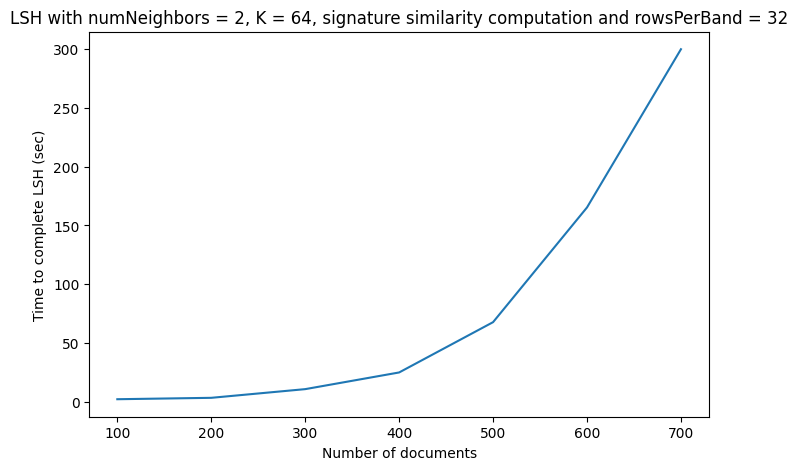

In [41]:
plt.figure(figsize=(8,5))
plt.plot(num_documents, time_to_complete)
plt.title('LSH with numNeighbors = 2, K = 64, signature similarity computation and rowsPerBand = 32')
plt.xlabel('Number of documents')
plt.ylabel('Time to complete LSH (sec)')
plt.show()

# **Experiment 2**

We conduct LSH computation using signature similarity for a steady number of documents, changing how many number of permutations K we use. Then, we compute the total absolute error (distance) between each document's signature similarity with its numNeighbors = 2 nearest neighbors and the jaccard similarity of the document and its two nearest neighbors. We want to evaluate how much the parameter K affects precision.



In [49]:
num_documents =  500
numNeighbors = 2
K_values = [10, 18, 26, 34, 42, 50]
similarity_choice = 2 # 1 : JacSim, 2 : SigSim
rowsPerBand = 4
total_error_values = []

for K in K_values:
  numDocuments = value
  frozenset_list = MyReadDataRoutine(value, 'DATA_1-docword.enron.txt')
  sig_m = MyMinHash(frozenset_list, K)
  avg_similarities, neighbors_dict = LSH(sig_m, rowsPerBand, similarity_choice)
  total_error = 0
  for doc in neighbors_dict.keys():
    neighbors = neighbors_dict[doc]

    for t in neighbors:
      jac_sim = MyJacSimWithOrderedLists(doc, t[0])
      difference = abs(jac_sim - t[1])
      total_error += difference

  total_error_values.append(total_error)


Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 1 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 1 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 1 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 1 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 1 rows per band.
Found documents with less than 2 potential pairs, restarting LSH for 2 rows per band.
Found documents with less than 2 potential pairs, rest

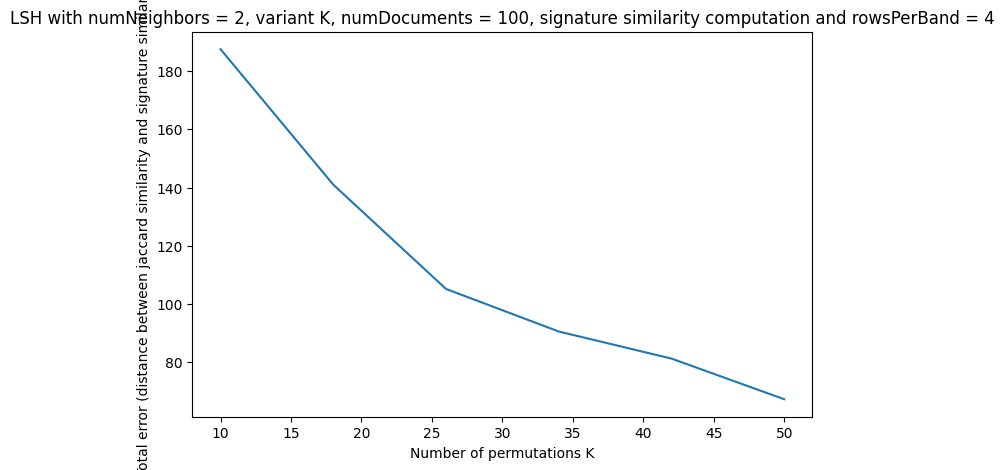

In [50]:
plt.figure(figsize=(8,5))
plt.plot(K_values, total_error_values)
plt.title('LSH with numNeighbors = 2, variant K, numDocuments = 100, signature similarity computation and rowsPerBand = 4')
plt.xlabel('Number of permutations K')
plt.ylabel('Total error (distance between jaccard similarity and signature similarity)')
plt.show()